# Why do boreholes in Uganda (or anywhere) fail? 

I imagine a lot of research and thought goes into choosing the drill sites, but does failure correlate with geographic details, population, or political reasons? Is there a trend based on which orgnization oversaw the installation or raised the capital? Can we create an ML model to determine if correlations exist?

I don't know anything about boreholes (and you may know more). But let's play around with some data to determine:
(1) What the data looks like
(2) What possible trends can we determine (if any)
(3) What don't we know or what would make this problem better?

![borehole](Waterpump.jpg)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd


I created a geojson (vector file) from this data source https://data.humdata.org/dataset/uganda-other 
This data comes from the UN Office for the Coordination of Humanitaria Affairs, S. & E. Africa (UNOCHA-ROSEA) (https://www.unocha.org/rosea).

I actually fused this data above with ground water depth maps of Uganda from the British Geological Survey. https://www.bgs.ac.uk/research/groundwater/international/africanGroundwater/mapsDownload.html

![borehole](humdata.png)

In [58]:
gdf=gpd.read_file('uganda_acholi_water_sources_merge_clean.geojson')   #read in the merged geojson
districts=gpd.read_file('uganda_distrcits.geojson')     #let's get a map of the Uganda Distrcits for context

In [16]:
print(len(gdf))    #How big is this dataframe?

11683


In [17]:
gdf.head(5)     #Show me the first 5 entries

,index_left,X,Y,DTWAFRICA_,S_02_ID_x,DNAME_2002_x,D_02_ID_x,C_02_ID_x,SNAME_2002_x,CNAME_2002_x,...,P_02_ID,FTYPE,LABEL_P,DTW,DEPTH_clean,LOCATION,MONTH_CONS,REHAB_BY,NOTE,geometry
0,0,33.125,3.211003,VS,305106,KITGUM,305,3051,LAGORO,CHUA,...,30510601,Populated Area,Laber,3.5,58,None,None,None,None,POINT (33.13316239620561 3.179302274159245)
1,3,33.125,3.161003,VS,305106,KITGUM,305,3051,LAGORO,CHUA,...,30510601,Populated Area,Laber,3.5,58,None,None,None,None,POINT (33.13316239620561 3.179302274159245)
2,515,33.175,3.161003,VS,312210,PADER,312,3122,WOL,AGAGO,...,30510601,Populated Area,Laber,3.5,58,None,None,None,None,POINT (33.13316239620561 3.179302274159245)
3,0,33.125,3.211003,VS,305106,KITGUM,305,3051,LAGORO,CHUA,...,30510601,Populated Area,Laber,3.5,49,None,None,None,None,POINT (33.13453067717418 3.180903416589643)
4,3,33.125,3.161003,VS,305106,KITGUM,305,3051,LAGORO,CHUA,...,30510601,Populated Area,Laber,3.5,49,None,None,None,None,POINT (33.13453067717418 3.180903416589643)


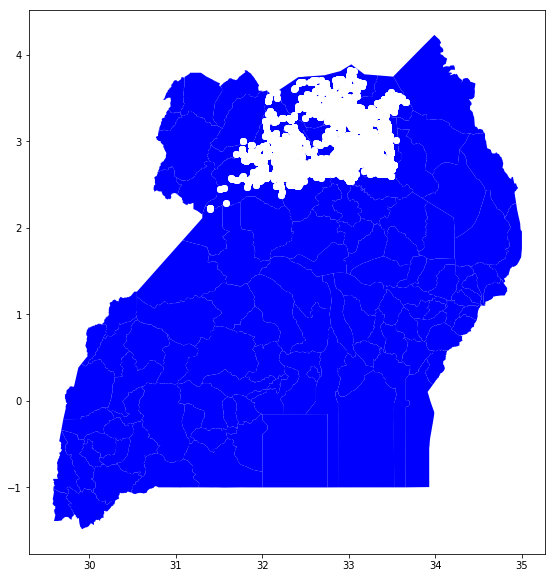

In [18]:
plt.rcParams['figure.figsize'] = (20, 10)
ax = districts.plot(color='blue')

for idx, row in gdf.iterrows():
    coordinates = row['geometry'].coords.xy
    x, y = coordinates[0][0], coordinates[1][0]

gdf.plot(ax=ax, color='white')

In [19]:
gdf.STATUS=gdf.STATUS.str.lower()
gdf['STATUS']=np.where(gdf['STATUS'].str.contains("abandoned"), 1,
             np.where(gdf['STATUS'].str.contains("blocked"), 2,
             np.where(gdf['STATUS'].str.contains("condemned"), 3,
             np.where(gdf['STATUS'].str.contains("deserted"), 4,
             np.where(gdf['STATUS'].str.contains("dried up"),5,
             np.where(gdf['STATUS'].str.contains("dry"),5,
             np.where(gdf['STATUS'].str.contains("fishing required"),6,
             np.where(gdf['STATUS'].str.contains("functional"),7,
             np.where(gdf['STATUS'].str.contains("low yield"),8,
             np.where(gdf['STATUS'].str.contains("needs repair"),9,
             np.where(gdf['STATUS'].str.contains("non functional"),10,
             np.where(gdf['STATUS'].str.contains("non-functional"),10,
             np.where(gdf['STATUS'].str.contains("silted"),11,
             np.where(gdf['STATUS'].str.contains("temporary down"),12,
             np.where(gdf['STATUS'].str.contains("unknown"), 0,0)))))))))))))))

gdf['VILLAGE'] = gdf['VILLAGE'].astype('category')
cat_columns = gdf.select_dtypes(['category']).columns
gdf[cat_columns] = gdf[cat_columns].apply(lambda x: x.cat.codes)

gdf['FUND_AGENC'] = gdf['FUND_AGENC'].astype('category')
cat_columns = gdf.select_dtypes(['category']).columns
gdf[cat_columns] = gdf[cat_columns].apply(lambda x: x.cat.codes)



....Lots of the above to create a cleaned dataframe. I'll spare you the details, but took many of the variables and created integer based categories to ingest into a predictive model. We want strings to become numbers, representative of categories.

In [53]:
df=pd.read_csv('train1.csv')    #this is the cleaned guy. 

Still some weird things going on with the columns....

In [54]:
df.fillna(value=99999, inplace=True)
df=df[['X', 'Y', 'S_02_ID_x', 'DNAME_2002', 'D_02_ID_x',
       'C_02_ID_x', 'SNAME_2002_x', 'CNAME_2002_x', '2002_CENSU', 'PROJ_POP_J',
       'Urban', 'Cvrg2008', 'FID_1', 'FID_1_1', 'DISTRICT', 'VILLAGE',
       'SOURCE_NAM', 'FUND_AGENC', 'YEAR_CONST', 'SOURCE_TYP', 'OWNER_TYPE',
       'STATUS', 'DEPTH', 'SWL', 'YIELD', 'RECEIVED_N', 'RECEIVED_E',
       'WSSC__EXIS', 'WSSC_TRAIN', 'CONTRACTOR', 'Y_UTM200', 'DNAME_2010',
       'DNAME_2006', 'CNAME_2006', 'SNAME_2006', 'PNAME_2006', 'FID_2',
       'D_02_ID_y', 'PNAME_2002', 'P_02_ID', 'YPE', 'LABEL_P', 'DTW',
       'DEPTH_clean', 'uid']]
#what ARE some of these variables? Little to know documentation avilable

print(len(df))

10222


We want to, basically, create a model to predict the well status. So let's see what the population of statuses that we have:


In [55]:
df.groupby('STATUS').count()['X']

STATUS
1      322
2        6
3        3
4        4
5       15
6        2
7     9790
8        4
9        3
10      52
11      21
Name: X, dtype: int64

:scream: So many class '7'!!!!!!!


<b>Question:</b> Why would that a problem?






In [39]:
to_remove = np.random.choice(df[df['STATUS']==7].index,size=9500,replace=False)   #OK waaay too many functional wells. 
df=df.drop(to_remove)

#pare it down to things that I can ascribe meaning to. Maybe faulty? May have removed important/meaningful information?
df_keys=df[['X', 'Y', '2002_CENSU','PROJ_POP_J', 'Urban', 'Cvrg2008',  'DISTRICT', 'VILLAGE','STATUS',
       'SOURCE_NAM', 'FUND_AGENC', 'YEAR_CONST', 'SOURCE_TYP', 'OWNER_TYPE','DEPTH', 'SWL', 'YIELD', 'RECEIVED_N',
       'RECEIVED_E', 'WSSC__EXIS', 'WSSC_TRAIN', 'CONTRACTOR', 'Y_UTM200','YPE',
       'LABEL_P', 'DTW', 'DEPTH_clean','uid']]



In [40]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X = df_keys[['X', 'Y', '2002_CENSU','PROJ_POP_J', 'Urban',  'DISTRICT', 'VILLAGE',
       'SOURCE_NAM', 'FUND_AGENC', 'YEAR_CONST', 'SOURCE_TYP', 'OWNER_TYPE','DEPTH', 'SWL', 'YIELD', 'RECEIVED_N',
       'RECEIVED_E', 'WSSC__EXIS', 'WSSC_TRAIN', 'CONTRACTOR', 'Y_UTM200','YPE', 'DTW', 'DEPTH_clean','uid']].values.reshape(-1,25)
y = df_keys['STATUS']     #Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)



In [56]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(multi_class='multinomial',solver='newton-cg').fit(X_train, y_train)
logmodel.coef_[0]
coefs=logmodel.coef_[0]
top_five = np.argpartition(coefs, -5)[-5:]
#top_three = np.argpartition(coefs, -3)[-3:]
print(df_keys.keys()[top_five])
#print(logmodel.predict(X_test)[0:13])
#print(y_test[0:13])


Index(['Cvrg2008', 'DISTRICT', 'Y_UTM200', '2002_CENSU', 'SOURCE_NAM'], dtype='object')


/usr/local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [59]:
gdf.groupby('SOURCE_NAM').count()['X']

SOURCE_NAM
AD14                              2
ASTU                              2
ASTU Detacth                      2
AVSI CPD                          6
Abalo kodi                        4
Abicinia                          3
Abilonino                         3
Abim                              7
Abong Rwot                        2
Abongo peke                       3
Abuga SW                          4
Acholibur Hqrs                    3
Acholibur P/S                     4
Acord                             3
Acuru P/S                         4
Acut tonga                        4
Adaga                             3
Adilang HC                        2
Adilang SS/Bk 14                  3
Adinga                            2
Adodi                             2
Adunu West                        4
Agole                             4
Agole PS                         12
Agoro Hqrs                        3
Agoro P.7                         3
AgoroH/center                     3
Agoromin IDP     

In [46]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    title = title

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes  #[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [48]:
np.set_printoptions(precision=2)
y_pred=logmodel.predict(X_test)



<b>Question:</b> Why do we predict on a 'test' set? What is unique or different about this set relative to what we trained on?

Confusion matrix, without normalization
[[86  0  0  0  0  0 28  0  0  1]
 [ 1  1  0  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [ 8  0  0  0  0  0 25  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  0  3  1  7  0]
 [ 4  0  0  0  0  0  3  0  0  2]]


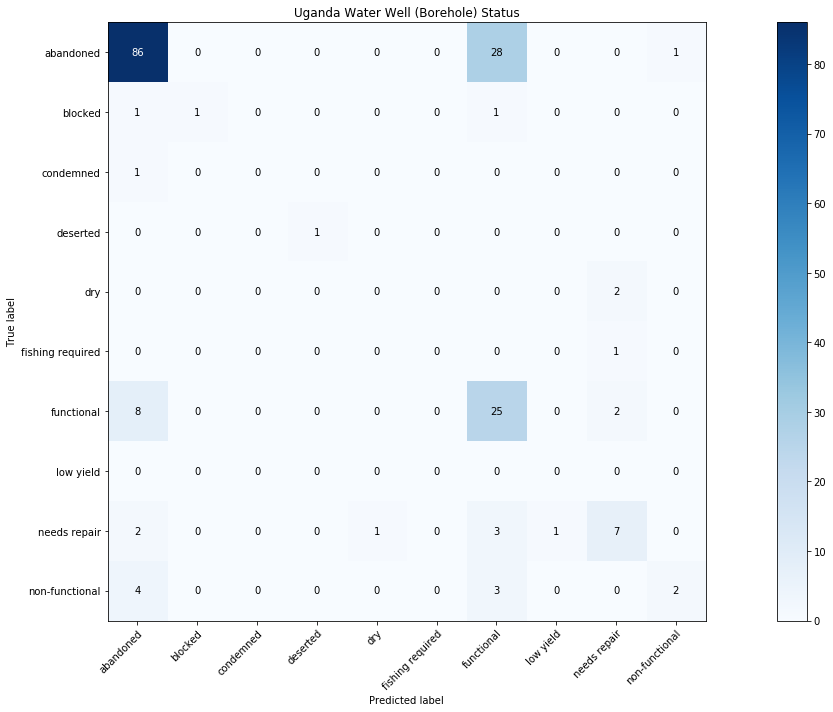

In [49]:
y_test=y_test.values.reshape((181, -1))
class_names=['abandoned','blocked','condemned','deserted','dry','fishing required','functional','low yield','needs repair','non-functional','silted']
plot_confusion_matrix(np.array(y_pred), y_test, classes=class_names,title='Uganda Water Well (Borehole) Status')


plt.show()


